In [1]:
# Data Processing Imports
import os
import numpy as np
import pandas as pd
from skimage.transform import resize, rotate, resize 
from skimage.io import imread
import matplotlib.pyplot as plt
import random
import copy

# Logger Imports
import time
import logging
import sys
from logging.handlers import TimedRotatingFileHandler

# Model Specific Imports
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

# Visulaization and metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import fbeta_score
from sklearn.metrics import roc_curve, auc, RocCurveDisplay

In [2]:
# Sets up all standardized logger stuff
FORMATTER = logging.Formatter("%(asctime)s —  %(levelname)s — %(message)s")
LOG_FILE = "General_Script.log"

def get_console_handler():
    console_handler = logging.StreamHandler(sys.stdout)
    console_handler.setFormatter(FORMATTER)
    return console_handler

def get_file_handler():
    file_handler = TimedRotatingFileHandler(LOG_FILE, when='midnight')
    file_handler.setFormatter(FORMATTER)
    return file_handler

def get_logger(logger_name):
    logger = logging.getLogger(logger_name)
    
    if (logger.hasHandlers()): # important as removes duplicate loggers (and thus duplicate log entries)
        logger.handlers.clear()
    logger.setLevel(logging.DEBUG) # better to have too much log than not enough
    logger.addHandler(get_console_handler())
    logger.addHandler(get_file_handler())
    # with this pattern, it's rarely necessary to propagate the error up to parent
    logger.propagate = False
    return logger

logger = get_logger("General_Script")

In [3]:
# Loads all data from files. NOTE, the folder in which the img's are stored in dictates there health class. See comments for folder class

Categories_Durum=['CFP-CK1','CFP-CK2'] # [Infected, Healthy]
Categories_Bread=['CFP-CK3','CFP-CK4'] # [Infected, Healthy]
Categories_Test_B179 = ['CFP-B179-A','CFP-B179-B'] # [Infected, Healthy]
Categories_Test_B223 = ['CFP-B223-A','CFP-B223-B'] # [Infected, Healthy]

Infected_Categories = ['CFP-CK1', 'CFP-CK3', 'CFP-B179-A', 'CFP-B223-A']

All_Categories = [Categories_Durum, Categories_Bread, Categories_Test_B179, Categories_Test_B223]

# Path to be recursively searched for images
datadir='/birl2/users/sch923/Thesis/Data/Wheat/TestSamples' 

In [4]:
# Pre-processing step
img_arr, label_arr = [],[]
total_imgs, total_infected, total_healthy = 0, 0, 0

# creating species specific data sets
for Categories in All_Categories:
    img_arr.append(list())
    label_arr.append(list())
    
    for i in Categories:
        logger.info(f'loading category: {i}')    
        path=os.path.join(datadir,i) 
        image_count = 0
        
        for img_path in os.listdir(path):  
            img=imread(os.path.join(path,img_path))
            img_resized=resize(img,(150,150,3))  
            img_arr[len(img_arr)-1].append(img_resized) # Saves flat images
            label_arr[len(img_arr)-1].append(Categories.index(i)) # Applies category based on folder
            image_count += 1
            
        logger.info(f'loaded category: {i} successfully, found {image_count} images')
        
        # Entire Dataset metric collection
        total_imgs = total_imgs + image_count
        if i in Infected_Categories:
            total_infected = total_infected + image_count
        else:
            total_healthy = total_healthy + image_count

logger.info(f'Number Of Healthy Kernel Images Found: {total_healthy}')            
logger.info(f'Number Of Infected Kernel Images Found: {total_infected}')
logger.info(f'Total Number Of Images Found: {total_imgs}')


2022-02-09 10:19:36,480 —  INFO — loading category: CFP-CK1
2022-02-09 10:19:49,283 —  INFO — loaded category: CFP-CK1 successfully, found 43 images
2022-02-09 10:19:49,285 —  INFO — loading category: CFP-CK2
2022-02-09 10:19:59,372 —  INFO — loaded category: CFP-CK2 successfully, found 48 images
2022-02-09 10:19:59,374 —  INFO — loading category: CFP-CK3
2022-02-09 10:20:02,896 —  INFO — loaded category: CFP-CK3 successfully, found 24 images
2022-02-09 10:20:02,897 —  INFO — loading category: CFP-CK4
2022-02-09 10:20:07,547 —  INFO — loaded category: CFP-CK4 successfully, found 31 images
2022-02-09 10:20:07,548 —  INFO — loading category: CFP-B179-A
2022-02-09 10:20:11,893 —  INFO — loaded category: CFP-B179-A successfully, found 29 images
2022-02-09 10:20:11,894 —  INFO — loading category: CFP-B179-B
2022-02-09 10:20:24,846 —  INFO — loaded category: CFP-B179-B successfully, found 74 images
2022-02-09 10:20:24,848 —  INFO — loading category: CFP-B223-A
2022-02-09 10:20:26,967 —  INFO

In [5]:
# Data augmentation step for smaller data sets (durum and bread)
# Ensures there is no bias introduced by training data size


def augment_img(img):
    rot_img = rotate(image=img, angle=random.uniform(-350, 350), mode='edge')
    # skimage.util.crop(rot_img, ((50, 100), (50, 50), (0,0)), copy=False))
    return rot_img
    
durum_len = len(img_arr[0])
bread_len = len(img_arr[1])
aug_img_arr = copy.deepcopy(img_arr)
aug_label_arr = copy.deepcopy(label_arr)

# Durum wheat data augmentation
i = durum_len
logger.info(f'Starting data augmentation for durum wheat datasets')
while i < (durum_len + bread_len):
    for img, label in zip(img_arr[0], label_arr[0]):
        aug_img_arr[0].append(augment_img(img))
        aug_label_arr[0].append(label)
        i = i + 1
        if i >= (durum_len + bread_len):
            break
logger.info(f'Completed data augmentation for durum wheat datasets. Added ({(durum_len + bread_len) - durum_len})images.')

# Durum wheat data augmentation
i = bread_len
logger.info(f'Starting data augmentation for bread wheat datasets')
while i < (durum_len + bread_len):
    for img, label in zip(img_arr[1], label_arr[1]):
        aug_img_arr[1].append(augment_img(img))
        aug_label_arr[1].append(label)
        i = i + 1
        if i >= (durum_len + bread_len):
            break
logger.info(f'Completed data augmentation for bread wheat datasets. Added ({(durum_len + bread_len) - bread_len})images.')       


2022-02-09 10:20:39,763 —  INFO — Starting data augmentation for durum wheat datasets
2022-02-09 10:20:39,873 —  INFO — Completed data augmentation for durum wheat datasets. Added (55)images.
2022-02-09 10:20:39,873 —  INFO — Starting data augmentation for bread wheat datasets
2022-02-09 10:20:40,047 —  INFO — Completed data augmentation for bread wheat datasets. Added (91)images.


In [6]:
logger.info(f'Flattening images...')
aug_flat_arr, flat_arr = [], []

for group in aug_img_arr:
    aug_flat_arr.append(list())
    for img in group:
        aug_flat_arr[len(aug_flat_arr)-1].append(img.flatten())

for group in img_arr:
    flat_arr.append(list())
    for img in group:
        flat_arr[len(flat_arr)-1].append(img.flatten())        
        
logger.info(f'Image flattening complete!')

2022-02-09 10:20:40,168 —  INFO — Flattening images...
2022-02-09 10:20:40,362 —  INFO — Image flattening complete!


In [7]:
# Slicing of input data into seperate dataframes (two for each data set), one containing image data and the other containing class data

# Conversion of flat_arr, aug_flat_arr and there associated label arrays to lists of arrays 
list_arr_fun = lambda l : np.array(l)
flat_img_list=list(map(list_arr_fun, flat_arr))
aug_flat_img_list=list(map(list_arr_fun, aug_flat_arr))
label_img_list=list(map(list_arr_fun, label_arr))
aug_label_img_list=list(map(list_arr_fun, aug_label_arr))

df_Durum=pd.DataFrame(aug_flat_img_list[0])
df_Bread=pd.DataFrame(aug_flat_img_list[1])
df_Complete=pd.DataFrame(np.append(flat_img_list[0], flat_img_list[1], axis=0))

df_Durum['label']=aug_label_img_list[0]
df_Bread['label']=aug_label_img_list[1]
df_Complete['label']=np.append(label_img_list[0], label_img_list[1], axis=0)

# creative slicing image/label dataframes to get the in row fromat for use in ML training/testing
x_Durum=df_Durum.iloc[:,:-1] # Image data 
y_Durum=df_Durum.iloc[:,-1] # Label data

x_Bread=df_Bread.iloc[:,:-1] # Image data 
y_Bread=df_Bread.iloc[:,-1] # Label data

x_Complete=df_Complete.iloc[:,:-1] # Image data 
y_Complete=df_Complete.iloc[:,-1] # Label data


In [8]:
# Data Splitting, with a 20% test set size and 80% training set size

logger.info('======= Start Of Data Split =======')
x_train_Durum,x_test_Durum,y_train_Durum,y_test_Durum=train_test_split(x_Durum,y_Durum,test_size=0.20,random_state=77,stratify=y_Durum)
logger.info(f'Durum Splitted Successfully. Training Set Length = {len(y_train_Durum)}, Test Set Length = {len(y_test_Durum)}')
x_train_Bread,x_test_Bread,y_train_Bread,y_test_Bread=train_test_split(x_Bread,y_Bread,test_size=0.20,random_state=77,stratify=y_Bread)
logger.info(f'Bread Splitted Successfully. Training Set Length = {len(y_train_Bread)}, Test Set Length = {len(y_test_Bread)}')
x_train_Complete,x_test_Complete,y_train_Complete,y_test_Complete=train_test_split(x_Complete,y_Complete,test_size=0.20,random_state=77,stratify=y_Complete)
logger.info(f'Complete Splitted Successfully. Training Set Length = {len(y_train_Complete)}, Test Set Length = {len(y_test_Complete)}')
logger.info('Test Splitted Successfully')
logger.info('======= End Of Data Split =======\n')

2022-02-09 10:20:44,807 —  INFO — ======= Start Of Data Split =======
2022-02-09 10:20:44,999 —  INFO — Durum Splitted Successfully. Training Set Length = 116, Test Set Length = 30
2022-02-09 10:20:45,169 —  INFO — Bread Splitted Successfully. Training Set Length = 116, Test Set Length = 30
2022-02-09 10:20:45,306 —  INFO — Complete Splitted Successfully. Training Set Length = 116, Test Set Length = 30
2022-02-09 10:20:45,307 —  INFO — Test Splitted Successfully
2022-02-09 10:20:45,307 —  INFO — ======= End Of Data Split =======



In [9]:
# A generalized model that trains a given model, gathering time complexity stats about its training.
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

def modelTrainer(model, x_train, y_train, model_name, method_name):
    # Added StandardScaler step to model training pipeline to help with ML (Specifically Logical Regression) convergence problems.
    pipe = make_pipeline(StandardScaler(), model)
    logger.info(f"Starting to train {method_name} model...")
    start = time.time()
    pipe.fit(x_train,y_train)
    end = time.time()
    logger.info(f"The {model_name} model trained in: {str(end - start)} seconds")
    return pipe

In [10]:
# Logistic Regression Models
logger.info('======= Start Of Logistic Regression Model Generation =======')
LogR_param_grid={'penalty':['l2'], 'C':[0.1,1,10,100], 'max_iter':[1024], 'solver': ['lbfgs'] } 
LogR_model_durum=GridSearchCV(LogisticRegression(), LogR_param_grid, n_jobs=-1)
LogR_model_bread=GridSearchCV(LogisticRegression(), LogR_param_grid, n_jobs=-1)
LogR_model_complete=GridSearchCV(LogisticRegression(), LogR_param_grid, n_jobs=-1)

LogR_model_durum = modelTrainer(LogR_model_durum, x_train_Durum, y_train_Durum, "Durum", "LogR")
LogR_model_bread = modelTrainer(LogR_model_bread, x_train_Bread, y_train_Bread, "Bread", "LogR")
LogR_model_Complete = modelTrainer(LogR_model_Complete, x_train_Complete, y_train_Complete, "Complete", "LogR")


2022-02-09 10:20:45,568 —  INFO — ======= Start Of Logistic Regression Model Generation =======
2022-02-09 10:20:45,570 —  INFO — Starting to train LogR model...
2022-02-09 10:21:04,304 —  INFO — The Durum model trained in: 18.73352074623108 seconds
2022-02-09 10:21:04,308 —  INFO — Starting to train LogR model...
2022-02-09 10:21:11,148 —  INFO — The Bread model trained in: 6.83912205696106 seconds
2022-02-09 10:21:11,151 —  INFO — Starting to train LogR model...
2022-02-09 10:21:17,501 —  INFO — The Complete model trained in: 6.348718166351318 seconds


In [11]:
# SVM Models
logger.info('======= Start Of SVM Model Generation =======')
SVM_param_grid={'C':[0.1,1,10,100],'gamma':[0.0001,0.001,0.1,1],'kernel':['rbf','poly']}
SVM_model_Durum=GridSearchCV(svm.SVC(probability=True), SVM_param_grid, n_jobs=-1)
SVM_model_Bread=GridSearchCV(svm.SVC(probability=True), SVM_param_grid, n_jobs=-1)
SVM_model_Complete=GridSearchCV(svm.SVC(probability=True), SVM_param_grid, n_jobs=-1)
SVM_model_Durum = modelTrainer(SVM_model_Durum, x_train_Durum, y_train_Durum, "Durum", "SVM")
SVM_model_Bread = modelTrainer(SVM_model_Bread, x_train_Bread, y_train_Bread, "Bread", "SVM")
SVM_model_Complete = modelTrainer(SVM_model_Complete, x_train_Complete, y_train_Complete, "Complete", "SVM")


2022-02-09 10:21:17,628 —  INFO — ======= Start Of SVM Model Generation =======
2022-02-09 10:21:17,630 —  INFO — Starting to train SVM model...
2022-02-09 10:22:16,353 —  INFO — The Durum model trained in: 58.72239017486572 seconds
2022-02-09 10:22:16,357 —  INFO — Starting to train SVM model...
2022-02-09 10:23:04,460 —  INFO — The Bread model trained in: 48.1023952960968 seconds
2022-02-09 10:23:04,467 —  INFO — Starting to train SVM model...
2022-02-09 10:23:53,232 —  INFO — The Complete model trained in: 48.76415491104126 seconds


In [12]:
# K Nearest Neighbors Models
logger.info('======= Start Of K Nearest Neighbors Model Generation =======')
KNN_param_grid={'n_neighbors':[5], 'weights':['uniform', 'distance']}
KNN_model_Durum=GridSearchCV(KNeighborsClassifier(), KNN_param_grid, n_jobs=-1)
KNN_model_Bread=GridSearchCV(KNeighborsClassifier(), KNN_param_grid, n_jobs=-1)
KNN_model_Complete=GridSearchCV(KNeighborsClassifier(), KNN_param_grid, n_jobs=-1)
KNN_model_Durum = modelTrainer(KNN_model_Durum, x_train_Durum, y_train_Durum, "Durum", "KNN")
KNN_model_Bread = modelTrainer(KNN_model_Bread, x_train_Bread, y_train_Bread, "Bread", "KNN")
KNN_model_Complete = modelTrainer(KNN_model_Complete, x_train_Complete, y_train_Complete, "Complete", "KNN")


2022-02-09 10:23:53,366 —  INFO — ======= Start Of K Nearest Neighbors Model Generation =======
2022-02-09 10:23:53,368 —  INFO — Starting to train KNN model...
2022-02-09 10:23:54,400 —  INFO — The Durum model trained in: 1.032095193862915 seconds
2022-02-09 10:23:54,402 —  INFO — Starting to train KNN model...
2022-02-09 10:23:55,407 —  INFO — The Bread model trained in: 1.0039722919464111 seconds
2022-02-09 10:23:55,408 —  INFO — Starting to train KNN model...
2022-02-09 10:23:56,427 —  INFO — The Complete model trained in: 1.0183837413787842 seconds


In [13]:
# Random Forest Models

logger.info('======= Start Of Random Forest Model Generation =======')
RanF_param_grid={'n_estimators':[100], 'criterion': ['gini', 'entropy']}
RanF_model_Durum=GridSearchCV(RandomForestClassifier(), RanF_param_grid, n_jobs=-1)
RanF_model_Bread=GridSearchCV(RandomForestClassifier(), RanF_param_grid, n_jobs=-1)
RanF_model_Complete=GridSearchCV(RandomForestClassifier(), RanF_param_grid, n_jobs=-1)
RanF_model_Durum = modelTrainer(RanF_model_Durum, x_train_Durum, y_train_Durum, "Durum", "RanF")
RanF_model_Bread = modelTrainer(RanF_model_Bread, x_train_Bread, y_train_Bread, "Bread", "RanF")
RanF_model_Complete = modelTrainer(RanF_model_Complete, x_train_Complete, y_train_Complete, "Complete", "RanF")

2022-02-09 10:23:56,545 —  INFO — ======= Start Of Random Forest Model Generation =======
2022-02-09 10:23:56,547 —  INFO — Starting to train RanF model...
2022-02-09 10:23:58,814 —  INFO — The Durum model trained in: 2.2670485973358154 seconds
2022-02-09 10:23:58,815 —  INFO — Starting to train RanF model...
2022-02-09 10:24:00,768 —  INFO — The Bread model trained in: 1.951986312866211 seconds
2022-02-09 10:24:00,769 —  INFO — Starting to train RanF model...
2022-02-09 10:24:02,785 —  INFO — The Complete model trained in: 2.015026569366455 seconds


In [14]:
# Naive Bayes Models
logger.info('======= Start Of Naive Bayes Generation =======')
#TODO

2022-02-09 10:24:02,910 —  INFO — ======= Start Of Naive Bayes Generation =======


        0         1         2         3         4         5         6      \
47   0.819608  0.819608  0.811765  0.823529  0.823529  0.815686  0.827451   
88   0.819608  0.827451  0.823529  0.823529  0.831373  0.827451  0.832680   
15   0.820131  0.827974  0.824052  0.823529  0.831373  0.827451  0.827451   
37   0.811765  0.808366  0.796253  0.815686  0.804444  0.784837  0.814553   
138  0.866884  0.868300  0.850980  0.867035  0.869428  0.850980  0.867185   
145  0.871906  0.867985  0.843105  0.874559  0.870907  0.837183  0.873755   
123  0.870588  0.866667  0.858249  0.870588  0.866667  0.856368  0.871003   
107  0.766222  0.781874  0.785072  0.771034  0.786580  0.787444  0.766977   
92   0.788851  0.805241  0.810482  0.789522  0.805208  0.808272  0.792128   
36   0.819608  0.827451  0.823529  0.819608  0.827451  0.823529  0.827625   
49   0.807843  0.807843  0.800000  0.811765  0.811765  0.803922  0.815686   
31   0.807843  0.815686  0.811765  0.811765  0.819608  0.815686  0.817342   

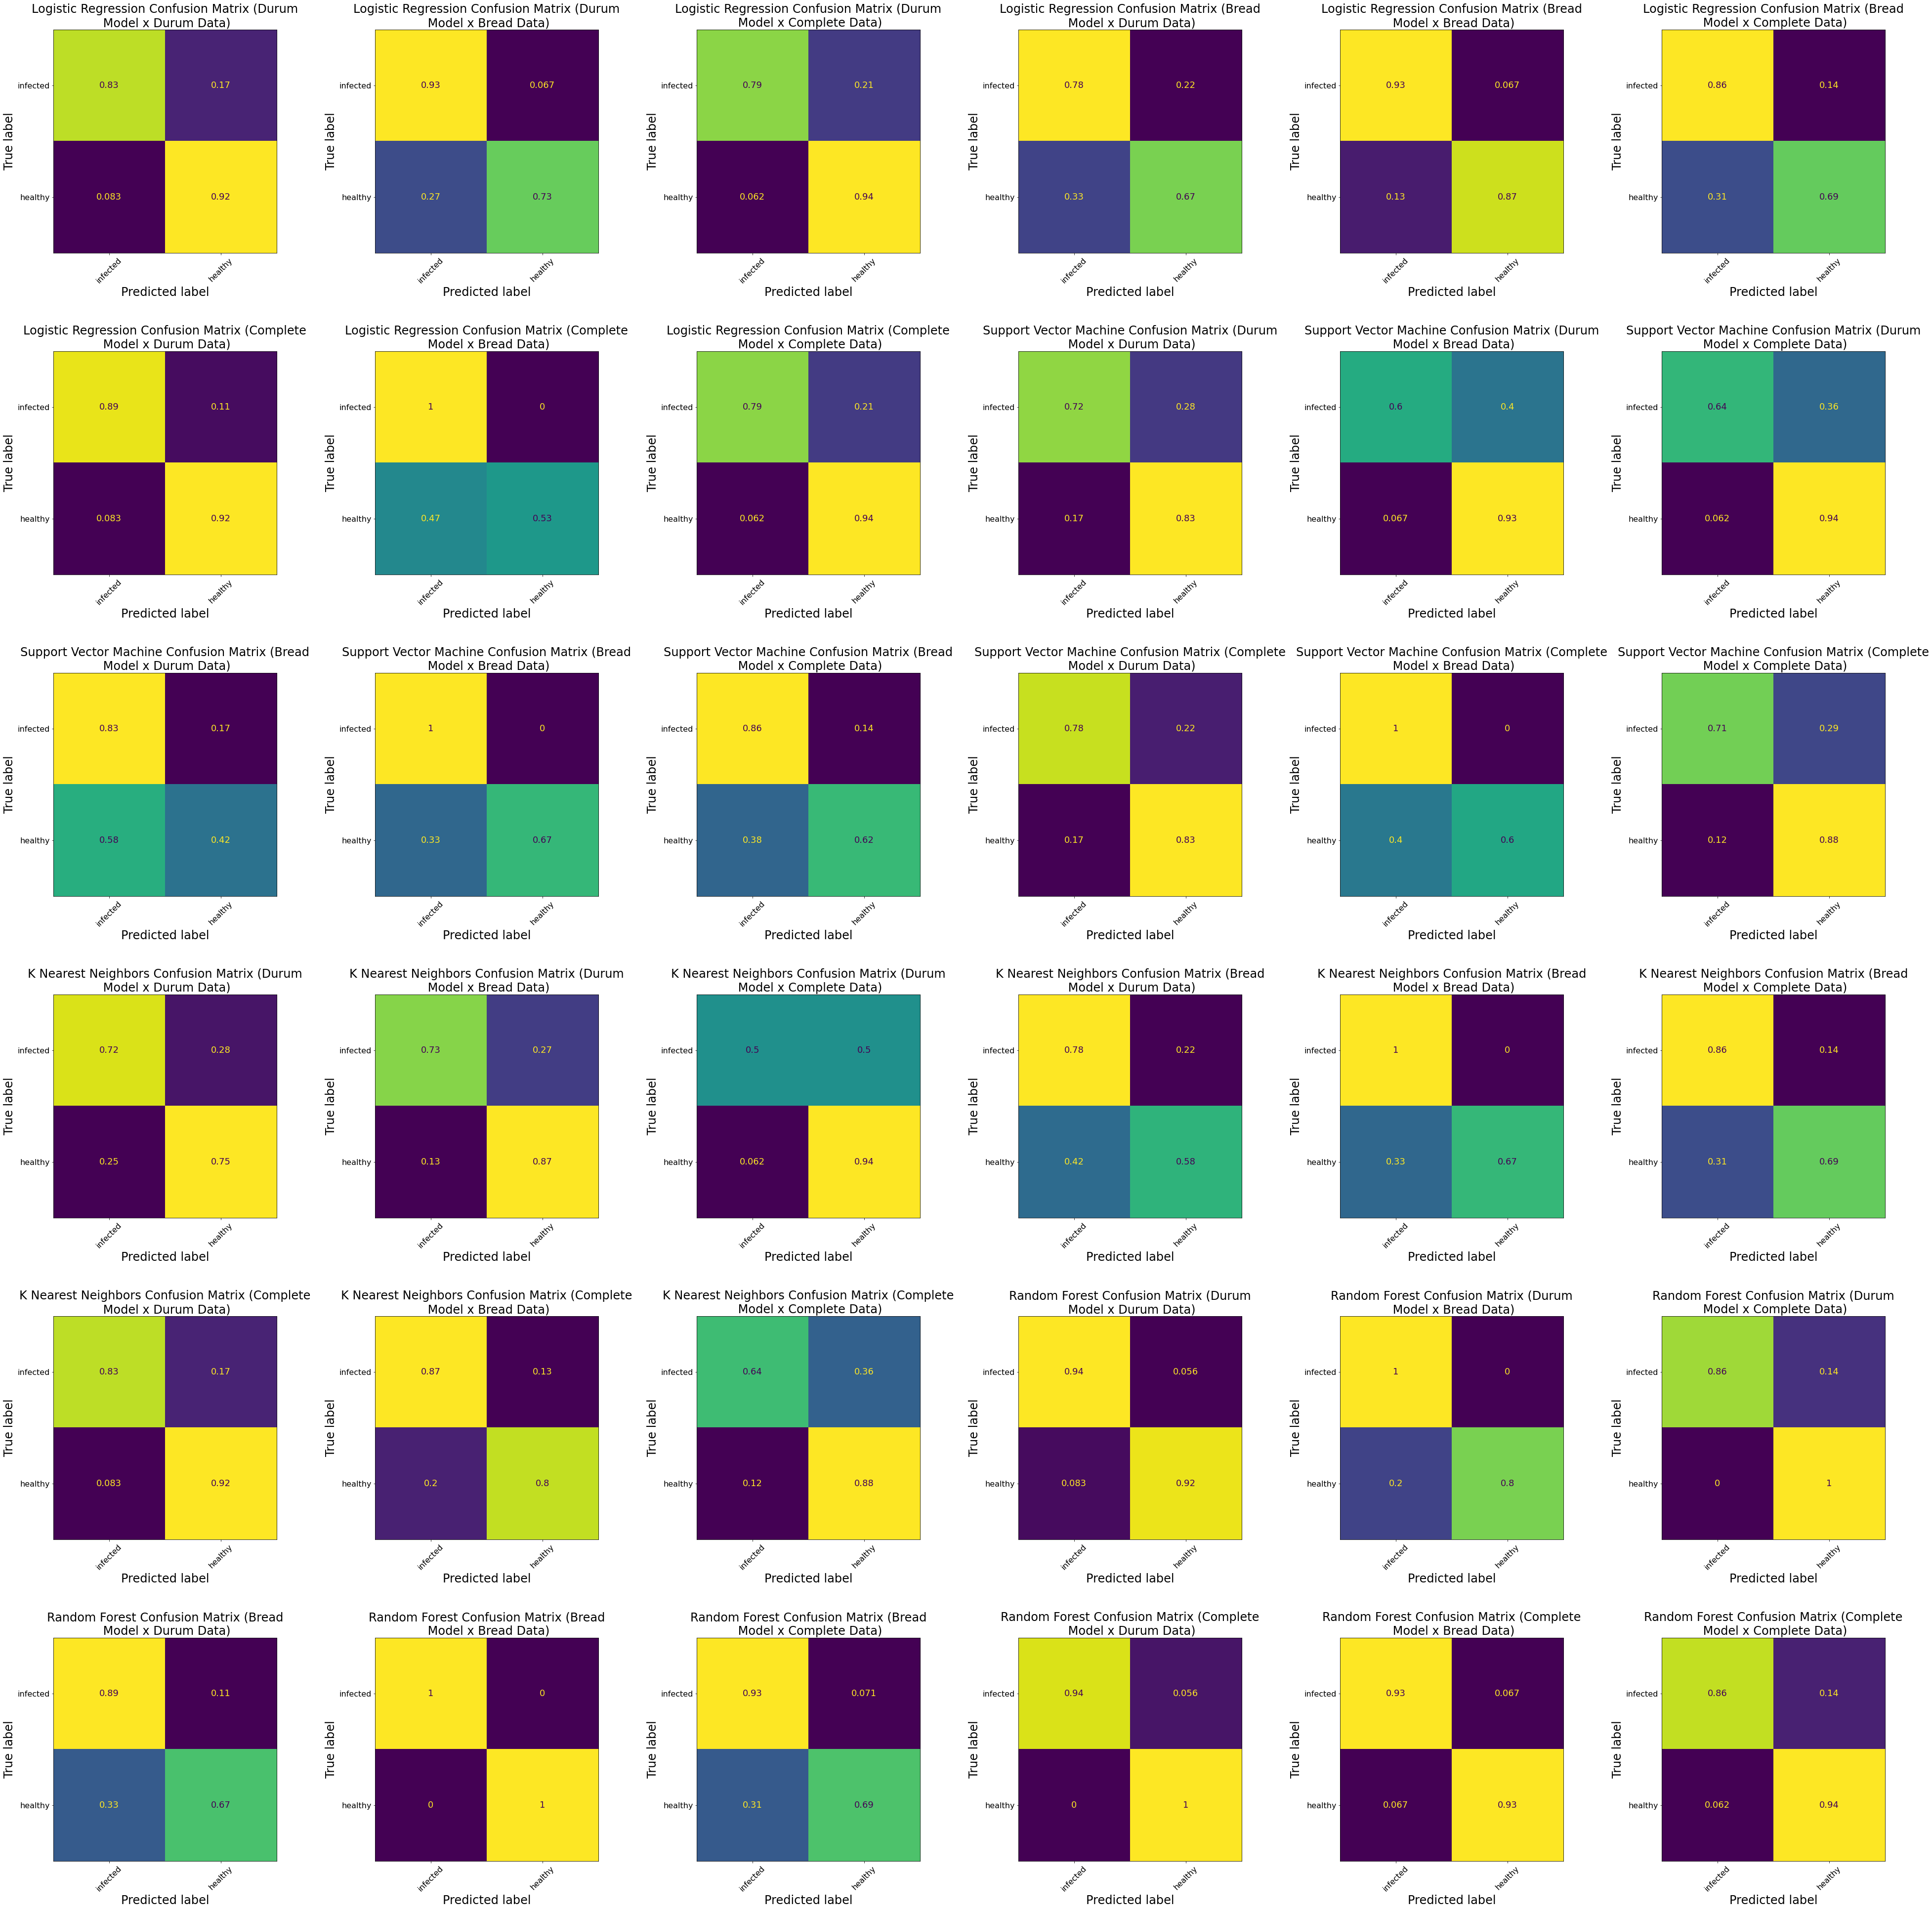

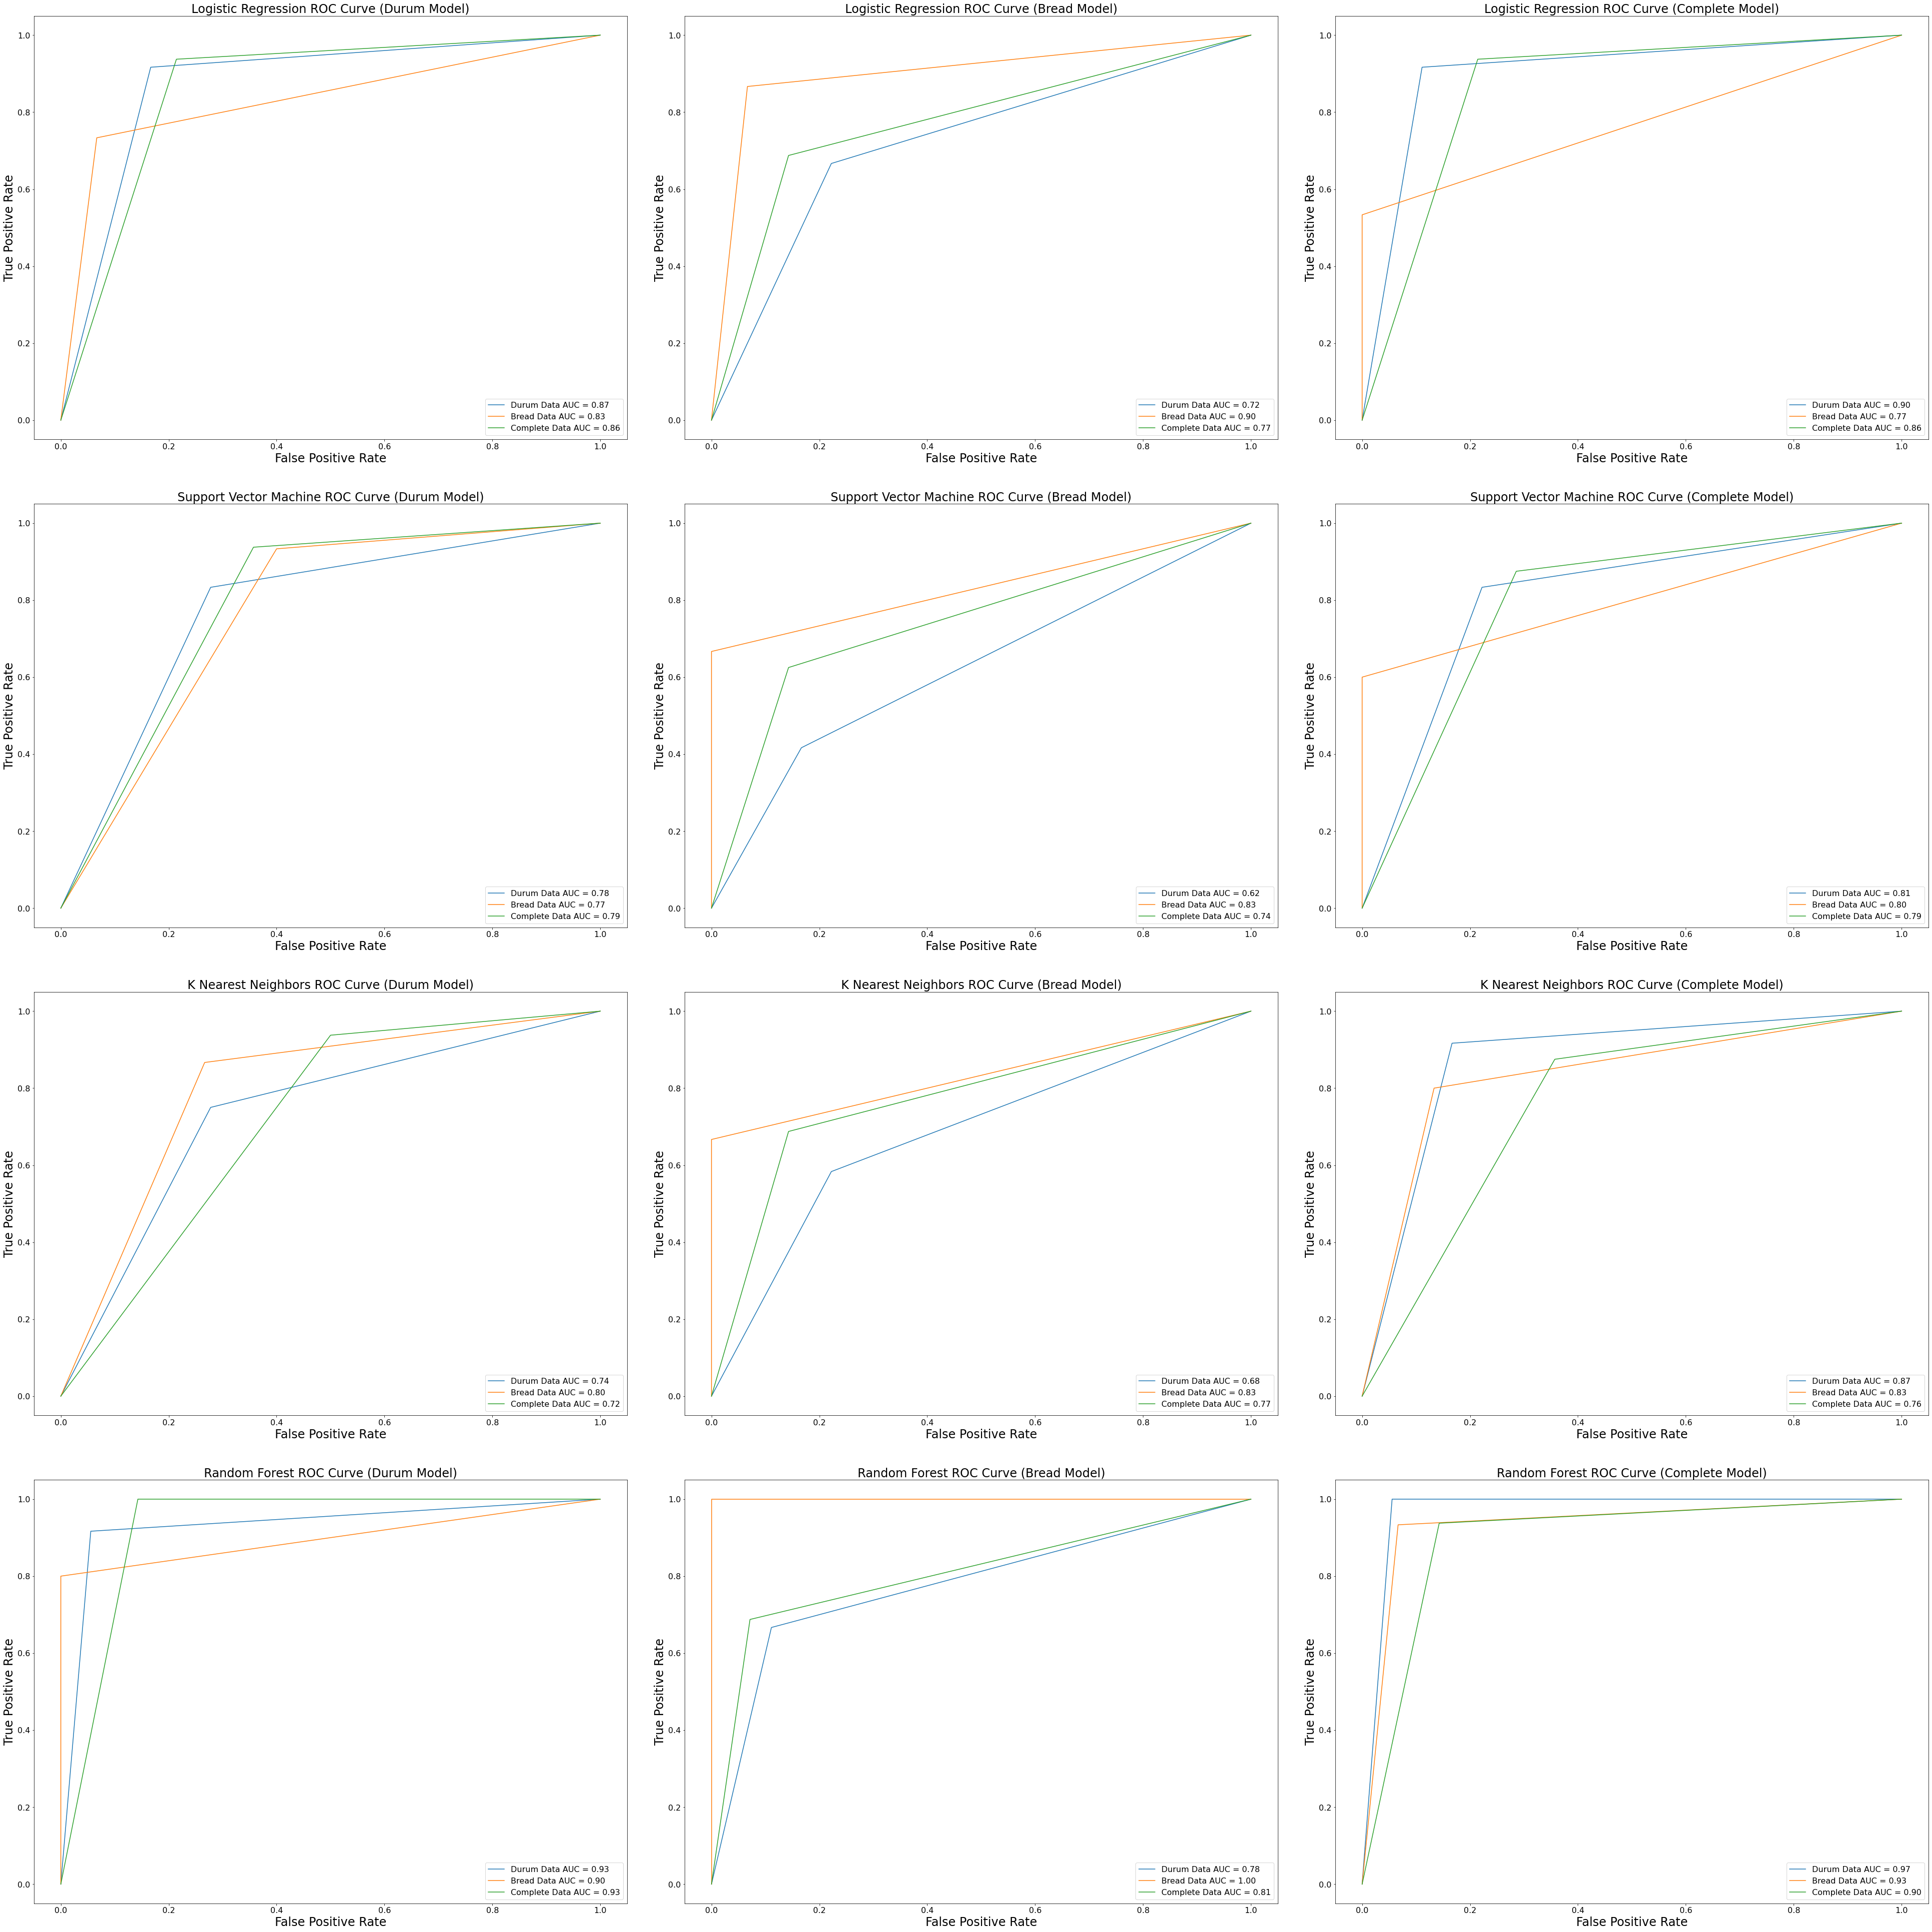

In [18]:
# Generation of confusion matrix for all models

Classification_Label = ['Logistic Regression', 'Support Vector Machine', 'K Nearest Neighbors', 'Random Forest']
Classification_Model = [ [LogR_model_Durum, LogR_model_Bread, LogR_model_Complete], [SVM_model_Durum, SVM_model_Bread, SVM_model_Complete], [KNN_model_Durum, KNN_model_Bread, KNN_model_Complete], [RanF_model_Durum, RanF_model_Bread, RanF_model_Complete]]
Train_Labels = ['Durum', 'Bread', 'Complete']
Test_Data_Sets = [(x_test_Durum, y_test_Durum), (x_test_Bread, y_test_Bread), (x_test_Complete, y_test_Complete)] # , (x_test_Test, y_test_Test)]
Data_Set_Label = ['Durum', 'Bread', 'Complete'] #, 'Test']


# Come common metrics used to gauge the models preformance
classification_model = []
train_data_used = []
test_data_used = []
false_positive_rate = [] # fp / (fp + tn)
false_negative_rate = [] # fn / (tp + fn)
true_negative_rate = [] # tn / (tn + fp)
negative_predictive_value = [] # tn / (tn + fn)
false_discovery_rate = [] # fp / (tp + fp)
true_positive_rate = [] # tp / (tp + fn)
precision = [] # tp / (tp + fp)
accuracy = [] # (tp + tn) / (tp + fp + fn + tn) 
f1_score = [] 
f2_score = []


# Setting up grid style plots for confusion matrix (conf) and ROC curves
fig_conf, axes_conf = plt.subplots(nrows=6, ncols=6, figsize=(55,55))
fig_roc, axes_roc = plt.subplots(nrows=4, ncols=3, figsize=(55,55))
axes_conf = axes_conf.flatten()
axes_roc = axes_roc.flatten()

# Accumulators for AUC bar chart
auc_index = []
auc_value = []
auc_data_label = []

i=0

for C_Label, C_Models in zip(Classification_Label, Classification_Model):
    for Model, T_Label in zip(C_Models, Train_Labels):
        for Test_Set, Test_Data_Label in zip(Test_Data_Sets, Data_Set_Label):
            
            y_test_pred = Model.predict(Test_Set[0])
            print(Test_Set[1])
            print(len(Test_Set[1]))
            print(y_test_pred)
            print(len(y_test_pred))
            # For confusion matrix
            cf_matrix = confusion_matrix(Test_Set[1], y_test_pred, normalize='true')
            
            ncf_matrix = cf_matrix.astype('float') / cf_matrix.sum(axis=1)[:, np.newaxis]            
            disp_conf = ConfusionMatrixDisplay(ncf_matrix ,display_labels=['infected', 'healthy'])
            disp_conf.plot(ax=axes_conf[i], xticks_rotation=45)
            disp_conf.im_.colorbar.remove()
            axes_conf[i].title.set_text(f"{C_Label} Confusion Matrix ({T_Label}\n Model x {Test_Data_Label} Data)")

            # For metrics table
            tn, fp, fn, tp = cf_matrix.ravel()
            classification_model.append(C_Label)
            train_data_used.append(T_Label)
            test_data_used.append(Test_Data_Label)
            false_positive_rate.append(fp / (fp + tn))
            false_negative_rate.append(fn / (tp + fn)) 
            true_negative_rate.append(tn / (tn + fp)) 
            negative_predictive_value.append(tn / (tn + fn))
            false_discovery_rate.append(fp / (tp + fp))
            true_positive_rate.append(tp / (tp + fn))
            precision.append(tp / (tp + fp)) 
            accuracy.append((tp + tn) / (tp + fp + fn + tn))
            f1_score.append(fbeta_score(Test_Set[1], y_test_pred, beta=1))
            f2_score.append(fbeta_score(Test_Set[1], y_test_pred, beta=2))

            # For auc_roc curve
            fpr, tpr, thresholds = roc_curve(Test_Set[1], y_test_pred)
            roc_auc = auc(fpr, tpr)
            disp_roc = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)  
            disp_roc.plot(ax=axes_roc[i//3], label=f"{Test_Data_Label} Data AUC = {roc_auc:.2f}")
            axes_roc[i//3].title.set_text(f"{C_Label} ROC Curve ({T_Label} Model)")

            # For AUC bar chart
            auc_index.append(f"{C_Label}\n({T_Label} Trained)")
            auc_value.append(float(f"{roc_auc:.2f}"))
            auc_data_label.append(f"{Test_Data_Label} Tested")
            
            i = i + 1

fig_conf.tight_layout(pad=3.0)
fig_conf.savefig('confusion_matrix.png')

fig_roc.tight_layout(pad=3.0)
fig_roc.savefig('ROC_curve.png')

In [16]:
# Generate metrics table and places in csv
metrics_df = pd.DataFrame(list(zip(classification_model,train_data_used,test_data_used,false_positive_rate,false_negative_rate,true_negative_rate,negative_predictive_value,false_discovery_rate,true_positive_rate,precision,accuracy,f1_score,f2_score)),
               columns =['Classifier', 'Training Data', 'Test Data', 'False Positive Rate', 'False Negative Rate', 'True Negative Rate', 'Negative Predictive Value', 'False Discovery Rate', 'True Positive Rate', 'Precision', 'Accuracy', 'F1 Score', 'F2 Score'])

metrics_df.to_csv('metrics_df.csv',index=False)


['K Nearest Neighbors\n(Bread Trained)', 'K Nearest Neighbors\n(Complete Trained)', 'K Nearest Neighbors\n(Durum Trained)', 'Logistic Regression\n(Bread Trained)', 'Logistic Regression\n(Complete Trained)', 'Logistic Regression\n(Durum Trained)', 'Random Forest\n(Bread Trained)', 'Random Forest\n(Complete Trained)', 'Random Forest\n(Durum Trained)', 'Support Vector Machine\n(Bread Trained)', 'Support Vector Machine\n(Complete Trained)', 'Support Vector Machine\n(Durum Trained)']


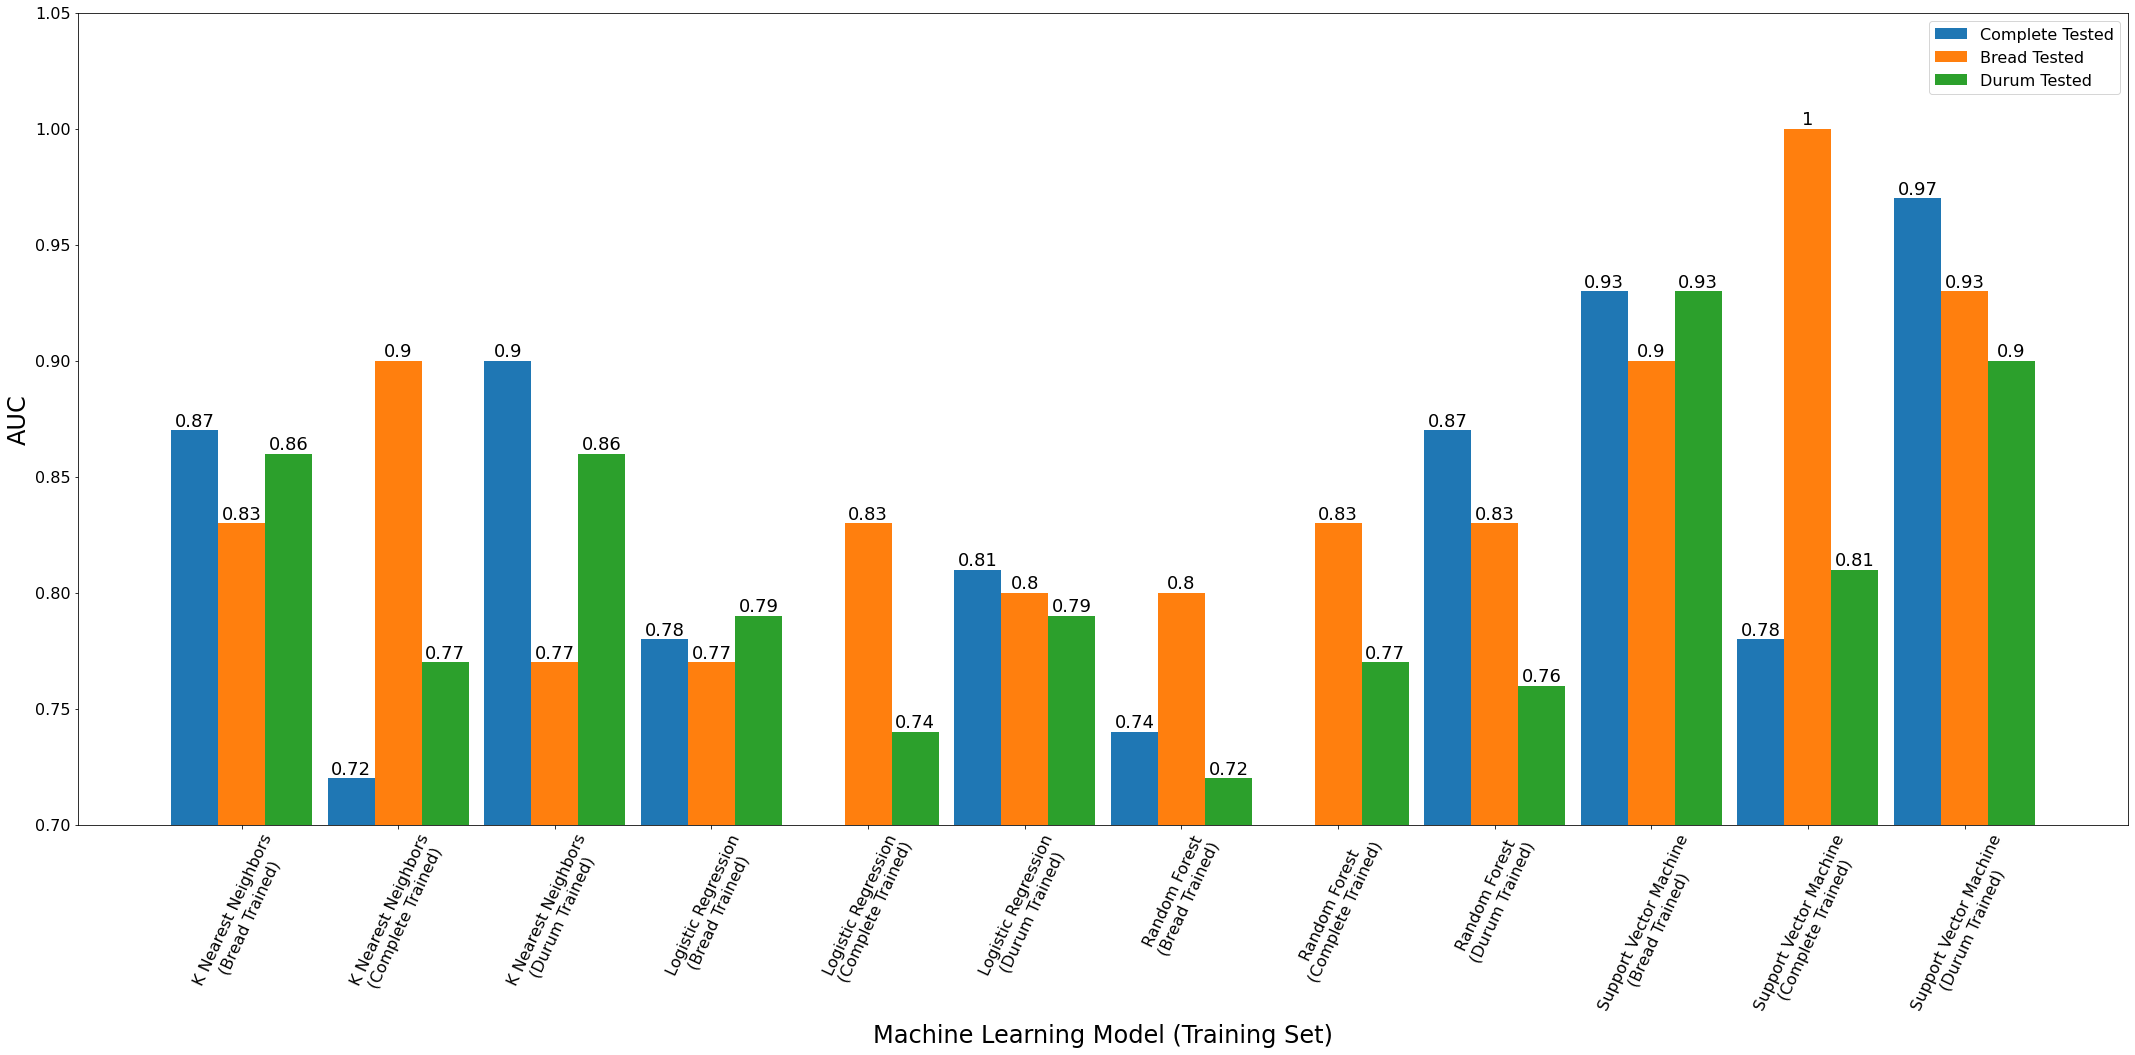

In [17]:
# Generate AUC for ROC curve bar chart

durum_auc = auc_value[0::3]
bread_auc = auc_value[1::3]
combined_auc = auc_value[2::3]
width = 0.30
plt.rc('font', size=18)          # controls default text sizes
plt.rc('axes', titlesize=24)     # fontsize of the axes title
plt.rc('axes', labelsize=24)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=16)    # fontsize of the tick labels
plt.rc('ytick', labelsize=16)    # fontsize of the tick labels
plt.rc('legend', fontsize=16)    # legend fontsize


auc_index_set_list = sorted(list(set(auc_index)))
auc_data_label_set_list = list(set(auc_data_label))
print(auc_index_set_list)
x = np.arange(len(auc_index_set_list))

fig, ax = plt.subplots(figsize=(30,15))

d_bar = ax.bar(x - 0.30, durum_auc, width)
b_bar = ax.bar(x + 0.00, bread_auc, width)
c_bar = ax.bar(x + 0.30, combined_auc, width)
ax.set_xticks(x)
ax.set_xticklabels(auc_index_set_list, rotation=65)
ax.set_xlabel("Machine Learning Model (Training Set)")
ax.set_ylabel("AUC")
ax.legend(auc_data_label_set_list)
ax.set(ylim=[0.7, 1.05])

ax.bar_label(d_bar)
ax.bar_label(b_bar)
ax.bar_label(c_bar)

fig.tight_layout()
plt.show()